In [1]:
#Import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.arima_model import ARMA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Import functions notebook and load data set here
import sys
sys.path.append("../")
from time_series_functions import *

In [3]:
df=pd.read_csv('../zillow_data.csv')

In [4]:
df=melt_data2(df)

In [5]:
df.set_index('time',inplace=True)

In [6]:
# Rename RegionName to be Zipcode
df=df.rename({'RegionName':'Zipcode'},axis='columns')

In [7]:
#drop no longer relevant columns
df.drop(['RegionID','SizeRank','City','CountyName'],axis=1,inplace=True)

In [8]:
Arizona_df= df[(df['State'] == 'AZ')]

In [9]:
Arizona_df

,Zipcode,State,Metro,value
time,,,,
1996-04-01,85032,AZ,Phoenix,95400.0
1996-04-01,85710,AZ,Tucson,94600.0
1996-04-01,85225,AZ,Phoenix,101200.0
1996-04-01,85308,AZ,Phoenix,124800.0
1996-04-01,85281,AZ,Phoenix,81200.0
...,...,...,...,...
2018-04-01,86332,AZ,Prescott,172500.0
2018-04-01,85645,AZ,Tucson,152300.0
2018-04-01,85928,AZ,Show Low,225100.0


In [10]:
Arizona_recent_yrs=Arizona_df['2009-01-01':'2018-04-01']

In [11]:
Arizona_recent_yrs

,Zipcode,State,Metro,value
time,,,,
2009-01-01,85032,AZ,Phoenix,190200.0
2009-01-01,85710,AZ,Tucson,171100.0
2009-01-01,85225,AZ,Phoenix,179900.0
2009-01-01,85308,AZ,Phoenix,212000.0
2009-01-01,85281,AZ,Phoenix,181300.0
...,...,...,...,...
2018-04-01,86332,AZ,Prescott,172500.0
2018-04-01,85645,AZ,Tucson,152300.0
2018-04-01,85928,AZ,Show Low,225100.0


In [12]:
Phoenix_data = Arizona_recent_yrs[(Arizona_recent_yrs['Metro'] == 'Phoenix')]

In [13]:
Phoenix_data
Phoenix_data=Phoenix_data.drop(['State','Metro'],axis=1)

In [14]:
top_10_zips_phx=Phoenix_data[(Phoenix_data['Zipcode'] == 85253)|(Phoenix_data['Zipcode'] == 85262)|
(Phoenix_data['Zipcode'] == 85377)| (Phoenix_data['Zipcode'] == 85255)|(Phoenix_data['Zipcode'] == 85266)|
                             (Phoenix_data['Zipcode'] == 85259)|(Phoenix_data['Zipcode'] == 85258)|
                             (Phoenix_data['Zipcode'] == 85018)|(Phoenix_data['Zipcode'] == 85263)|
                             (Phoenix_data['Zipcode'] == 85054)]

In [15]:
def get_zip(zipcode):
    top_10_zips_phx=Phoenix_data[(Phoenix_data['Zipcode'] == 85253)|(Phoenix_data['Zipcode'] == 85262)|
    (Phoenix_data['Zipcode'] == 85377)| (Phoenix_data['Zipcode'] == 85255)|(Phoenix_data['Zipcode'] == 85266)|
                             (Phoenix_data['Zipcode'] == 85259)|(Phoenix_data['Zipcode'] == 85258)|
                            (Phoenix_data['Zipcode'] == 85018)|(Phoenix_data['Zipcode'] == 85263)|
                             (Phoenix_data['Zipcode'] == 85054)]
    zip_zipcode=top_10_zips_phx[top_10_zips_phx['Zipcode']==zipcode]
    #zip_zipcode.drop(['index'],axis=1,inplace=True)
    zip_zipcode.reset_index(inplace=True)
    
    # shift by one period (month)
    resampled_shift_1 = zip_zipcode[['value']].shift(1)
    resampled_shift_1.bfill(inplace=True)

#reset the indexes to perform calculation of growth
    top_10_zips_phx = zip_zipcode.reset_index()
    resampled_shift_1 = resampled_shift_1.reset_index()

#Growth Calculation
    zip_zipcode['growth'] = (zip_zipcode['value'] - resampled_shift_1['value'])/(resampled_shift_1['value'])
    zip_zipcode['growth']= abs(zip_zipcode['growth'])
#set the index back to zipcode and time multi-index
    zip_zipcode.set_index(['time'],inplace=True)
    
    zip_zipcode.drop('Zipcode',axis=1,inplace=True)
    data= top_10_zips_phx
    print(f'The stationarity check for zipcode {zipcode} before adjustments:{stationarity_check(zip_zipcode.growth)}')
    
    #Original Plot
    fig, ax = plt.subplots()
    ax.plot(zip_zipcode.growth)
    ax.set_title(f"Original Zipcode Plot for {zipcode}");
    
    #log values and dropna
    log_zipcode= abs(np.log(zip_zipcode.growth))
    log_zipcode.dropna(inplace=True)
    
    # get roll mean and subtract
    roll_mean = log_zipcode.rolling(window=7,center=False).mean()
    data_minus_roll_mean = log_zipcode-roll_mean
    
    #Drop missing values
    data_minus_roll_mean.dropna(inplace=True)
    return data_minus_roll_mean
    #Plot the data minus roll mean
    #data_minus_roll_mean.plot(figsize=(10,6));
    fig, ax = plt.subplots()
    ax.plot(data_minus_roll_mean)
    ax.set_title(f"Final Zipcode Plot for {zipcode}");

    print(f'The stationarity check for zipcode {zipcode}, after adjustments:{stationarity_check(data_minus_roll_mean)}')
    


Results of Dickey-Fuller Test: 

Test Statistic                  -4.625586
p-value                          0.000116
#Lags Used                       3.000000
Number of Observations Used    108.000000
Critical Value (1%)             -3.492401
Critical Value (5%)             -2.888697
Critical Value (10%)            -2.581255
dtype: float64
The stationarity check for zipcode 85262 before adjustments:None


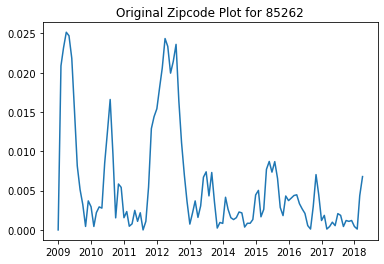

In [16]:
minus_roll_mean=get_zip(85262)

In [17]:
minus_roll_mean

time
2009-08-01    0.833810
2009-09-01    1.095072
2009-10-01    1.273354
2009-11-01    2.685576
2009-12-01    0.294163
                ...   
2017-12-01   -0.130577
2018-01-01    0.847745
2018-02-01    1.813654
2018-03-01   -1.752785
2018-04-01   -1.802878
Name: growth, Length: 98, dtype: float64

In [18]:
# find the index which allows us to split off 20% of the data
cutoff = round(minus_roll_mean.shape[0]*0.8)
cutoff

78

In [19]:
# Define train and test sets according to the index found above
train = minus_roll_mean[:cutoff]

test = minus_roll_mean[cutoff:]

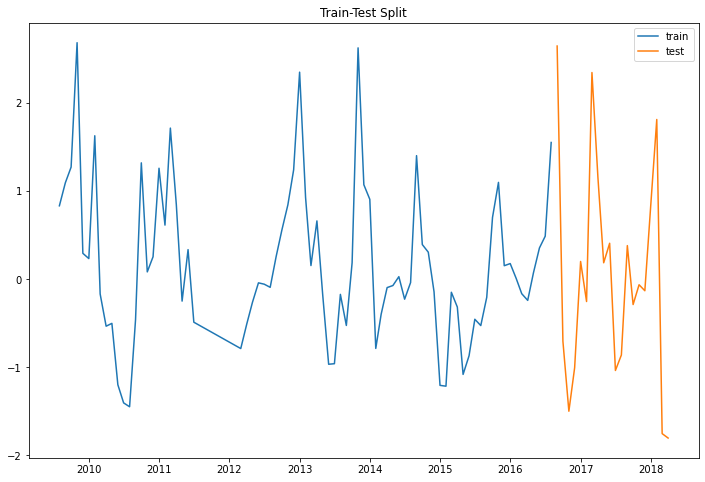

In [20]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.set_title('Train-Test Split');
plt.legend();

In [21]:
split = TimeSeriesSplit()

for train_ind, val_ind in split.split(train):
    print(train_ind, val_ind)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12] [13 14 15 16 17 18 19 20 21 22 23 24 25]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25] [26 27 28 29 30 31 32 33 34 35 36 37 38]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38] [39 40 41 42 43 44 45 46 47 48 49 50 51]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51] [52 53 54 55 56 57 58 59 60 61 62 63 64]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64] [65 66 67 68 69 70 71 72 73 74 75 76 77]


In [22]:
# we can perform this with the shift operator
# The prediction for the next day is the original series shifted to the future by one day.
baseline = train.shift(1)
baseline

time
2009-08-01         NaN
2009-09-01    0.833810
2009-10-01    1.095072
2009-11-01    1.273354
2009-12-01    2.685576
                ...   
2016-04-01   -0.164491
2016-05-01   -0.239986
2016-06-01    0.074547
2016-07-01    0.355224
2016-08-01    0.488633
Name: growth, Length: 78, dtype: float64

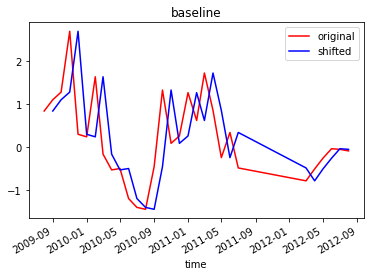

In [23]:
fig, ax = plt.subplots()

train[0:30].plot(ax=ax, c='r', label='original')
baseline[0:30].plot(ax=ax, c='b', label='shifted')
ax.set_title('baseline')
ax.legend();

In [24]:
np.sqrt(mean_squared_error(train[1:], baseline.dropna()))

0.8357031442302576

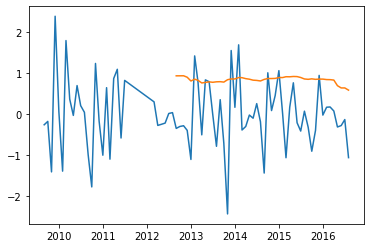

In [25]:
fig, ax = plt.subplots()
residuals = baseline[1:] - train[1:]
ax.plot(residuals.index, residuals)
ax.plot(residuals.index, residuals.rolling(30).std());

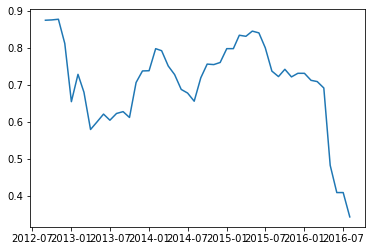

In [26]:
fig, ax = plt.subplots()

ax.plot(residuals.index, residuals.rolling(30).var());

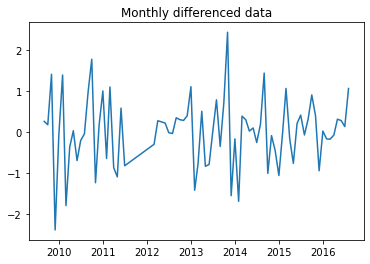

In [27]:
fig, ax = plt.subplots()
ax.plot(train.diff())
ax.set_title('Monthly differenced data');

In [28]:
p_val = adfuller(train.diff()[1:])[1]
print(f"The p-value associated with the Dickey-Fuller statistical test is {p_val},")
if p_val < 0.05:
    print(" so we can safely assume that the differenced data is stationary.")
else:
    print(" so we cannot reject the null hypothesis that the differenced data is \
not stationary.")

The p-value associated with the Dickey-Fuller statistical test is 2.8596637482671e-06,
 so we can safely assume that the differenced data is stationary.


In [29]:
ar_1 = ARIMA(train, order=(1, 1, 0)).fit()

# We put a typ='levels' to convert our predictions to remove the differencing performed.
ar_1.predict(typ='levels')

time
2009-08-01    0.000000
2009-09-01    0.833810
2009-10-01    1.044840
2009-11-01    1.239076
2009-12-01    2.414051
                ...   
2016-04-01   -0.131041
2016-05-01   -0.225471
2016-06-01    0.014073
2016-07-01    0.301259
2016-08-01    0.462982
Name: predicted_mean, Length: 78, dtype: float64

In [30]:
ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 growth   No. Observations:                   78
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 -94.001
Date:                Tue, 04 Jan 2022   AIC                            192.003
Time:                        18:19:23   BIC                            196.690
Sample:                             0   HQIC                           193.878
                                 - 78                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1923      0.101     -1.905      0.057      -0.390       0.006
sigma2         0.6725      0.093      7.215      0.000       0.490       0.855
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                 2.35
Prob(Q):                              0.67   Prob(JB):                         0.31
Heteroskedasticity (H):               0.43   Skew:                             0.25
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
random_walk_model = ARIMA(train, order=(0, 1, 0)).fit()
random_walk_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 growth   No. Observations:                   78
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 -95.438
Date:                Tue, 04 Jan 2022   AIC                            192.876
Time:                        18:19:24   BIC                            195.220
Sample:                             0   HQIC                           193.814
                                 - 78                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.6984      0.097      7.175      0.000       0.508       0.889
===================================================================================
Ljung-Box (L1) (Q):                   2.90   Jarque-Bera (JB):                 1.61
Prob(Q):                              0.09   Prob(JB):                         0.45
Heteroskedasticity (H):               0.39   Skew:                            -0.10
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
print(f'Random Walk AIC: {random_walk_model.aic}')
print(f'AR(1, 1, 0) AIC: {ar_1.aic}' )

Random Walk AIC: 192.8763339048707
AR(1, 1, 0) AIC: 192.00262760001354


In [33]:
y_hat_ar1 = ar_1.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_ar1))

0.8202501201854321

In [34]:
y_hat_rw = random_walk_model.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_rw))

0.8356789035305139

In [35]:
train.index

DatetimeIndex(['2009-08-01', '2009-09-01', '2009-10-01', '2009-11-01',
               '2009-12-01', '2010-01-01', '2010-02-01', '2010-03-01',
               '2010-04-01', '2010-05-01', '2010-06-01', '2010-07-01',
               '2010-08-01', '2010-09-01', '2010-10-01', '2010-11-01',
               '2010-12-01', '2011-01-01', '2011-02-01', '2011-03-01',
               '2011-04-01', '2011-05-01', '2011-06-01', '2011-07-01',
               '2012-03-01', '2012-04-01', '2012-05-01', '2012-06-01',
               '2012-07-01', '2012-08-01', '2012-09-01', '2012-10-01',
               '2012-11-01', '2012-12-01', '2013-01-01', '2013-02-01',
               '2013-03-01', '2013-04-01', '2013-05-01', '2013-06-01',
               '2013-07-01', '2013-08-01', '2013-09-01', '2013-10-01',
               '2013-11-01', '2013-12-01', '2014-01-01', '2014-02-01',
               '2014-03-01', '2014-04-01', '2014-05-01', '2014-06-01',
               '2014-07-01', '2014-08-01', '2014-09-01', '2014-10-01',
      

In [36]:
train_with_ind = train.reset_index()

In [37]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(1, 1, 0)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

1.903916838693681
1.2765253849743436
0.9576664872102884
0.7618448522673557
0.9690663005029907


In [38]:
ar_1.arparams

array([-0.19226759])

In [39]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(np.array(train.diff().shift(1).dropna()).reshape(-1, 1), train[1:].diff().dropna())
print(lr.coef_)

[-0.1945414]


In [40]:
ar_2 = ARIMA(train, order=(2, 1, 0)).fit()

ar_2.predict(typ='levels')

time
2009-08-01    0.000000
2009-09-01    0.833810
2009-10-01    1.044409
2009-11-01    1.169119
2009-12-01    2.305257
                ...   
2016-04-01   -0.083188
2016-05-01   -0.180932
2016-06-01    0.016970
2016-07-01    0.213913
2016-08-01    0.390576
Name: predicted_mean, Length: 78, dtype: float64

In [41]:
print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)

192.8763339048707
192.00262760001354
189.6049161048487


In [42]:
y_hat_ar1 = ar_2.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_ar1))

0.7969366477063783

In [43]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(2, 1, 0)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

1.8541752278538375
1.2738847648763139
0.9517046359930913
0.7548329763882479
1.0551447089574562


### Moving Avg

In [44]:
ma_1 = ARIMA(train, order=(0, 0, 1)).fit()
y_hat = ma_1.predict(typ='levels')
y_hat

time
2009-08-01    0.187302
2009-09-01    0.472105
2009-10-01    0.527815
2009-11-01    0.619895
2009-12-01    1.409762
                ...   
2016-04-01    0.086657
2016-05-01   -0.008072
2016-06-01    0.236719
2016-07-01    0.258183
2016-08-01    0.325140
Name: predicted_mean, Length: 78, dtype: float64

In [45]:
ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 growth   No. Observations:                   78
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 -87.530
Date:                Tue, 04 Jan 2022   AIC                            181.061
Time:                        18:19:26   BIC                            188.131
Sample:                             0   HQIC                           183.891
                                 - 78                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1873      0.153      1.224      0.221      -0.113       0.487
ma.L1          0.5981      0.097      6.175      0.000       0.408       0.788
sigma2         0.5493      0.090      6.113      0.000       0.373       0.725
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):                 6.99
Prob(Q):                              0.69   Prob(JB):                         0.03
Heteroskedasticity (H):               0.45   Skew:                             0.70
Prob(H) (two-sided):                  0.05   Kurtosis:                         3.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [46]:
ma_1 = ARIMA(train, order=(0, 1, 1)).fit()

print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)

192.8763339048707
192.00262760001354
189.6049161048487
190.34269467363893


In [47]:
y_hat_ar1 = ma_1.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_ar1))

0.8113439072353474

In [48]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(0, 1, 1)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

1.8137596352900363
1.2363441785052478
0.9539090521088296
0.7533095111301035
1.0193285502729255


In [49]:
ma_2 = ARIMA(train, order=(0, 1, 2)).fit()
y_hat = ma_2.predict(typ='levels')
y_hat

time
2009-08-01    0.000000
2009-09-01    0.833810
2009-10-01    1.068109
2009-11-01    1.139781
2009-12-01    2.300294
                ...   
2016-04-01    0.069818
2016-05-01   -0.032842
2016-06-01    0.217948
2016-07-01    0.238637
2016-08-01    0.310987
Name: predicted_mean, Length: 78, dtype: float64

In [50]:
print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)
print(ma_2.aic)

192.8763339048707
192.00262760001354
189.6049161048487
190.34269467363893
183.24068261838195


In [51]:
y_hat_ar1 = ma_2.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_ar1))

0.7713979201363654

In [52]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(0, 1, 2)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

2.2573536818048208
0.7405550096531764
0.9589694183119248
0.885598631110374
0.599962466377704


### ARMA

In [53]:
arma_21 = ARIMA(train, order=(2, 1, 2)).fit()

In [54]:
print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)
print(ma_2.aic)
print(arma_21.aic)

192.8763339048707
192.00262760001354
189.6049161048487
190.34269467363893
183.24068261838195
190.86363850866042


In [55]:
def find_rmse(model, train_data=train):
    y_hat = model.predict(typ='levels')
    return np.sqrt(mean_squared_error(train_data, y_hat))

In [56]:
print(find_rmse(random_walk_model))
print(find_rmse(ar_1))
print(find_rmse(ar_2))
print(find_rmse(ma_1))
print(find_rmse(ma_2))
print(find_rmse(arma_21))

0.8356789035305139
0.8202501201854321
0.7969366477063783
0.8113439072353474
0.7713979201363654
0.7838216016710032


In [57]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(2, 1, 2)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

1.7712508650372816
1.413782214856694
1.0067192377144811
0.7272025387632933
1.03087482054279


In [58]:
def find_rmse_test(model, test_data=test):
    y_hat = model.predict(start=test_data.index[1], end=test_data.index[-1], typ='levels')
    return np.sqrt(mean_squared_error(test_data, y_hat))

In [59]:
print(find_rmse_test(random_walk_model))
print(find_rmse_test(ar_1))
print(find_rmse_test(ar_2))
print(find_rmse_test(ma_1))
print(find_rmse_test(ma_2))
print(find_rmse_test(arma_21))

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'